# Example for a simple ReLU MLP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

from matplotlib.colors import LinearSegmentedColormap, ListedColormap, TwoSlopeNorm
from tqdm import tqdm
import matplotlib.patches as mpatches
import random

import numpy as np
from fast_iot.model import ReluMLP

ModuleNotFoundError: No module named 'fast_iot'

In [ ]:
def plot_cell_sdf(
        net,
        resolution: int = 300
    ):
    """
    Plot SDF heatmap with activation boundaries.
    
    Note: This function is designed for 2D input, 1D output models only.
    """
    if net.input_dim != 2 or net.output_dim != 1:
        print(f"Warning: plot_cell_sdf expects 2D input and 1D output, got input_dim={net.input_dim}, output_dim={net.output_dim}")
        return
    
    # ---------- grid & network pass ----------
    x = torch.linspace(-1, 1, resolution)
    y = torch.linspace(-1, 1, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

    with torch.no_grad():
        net = net.to(device)
        sdf_vals, preacts = net.eval_activations(grid_pts.to(device))  # sdf (N,), acts (N, L*H)

    # infer layer setup
    L = net.num_layers
    H = net.hidden_dim

    sdf_grid = sdf_vals.view(resolution, resolution).cpu().numpy()
    preacts = preacts.view(resolution, resolution, L, H).cpu()

    # ---------- figure ----------
    fig, ax = plt.subplots(figsize=(10, 8))

    # ---- SDF heat‑map ----
    vmin, vmax = sdf_grid.min(), sdf_grid.max()
    if vmin >= 0:
        cmap = LinearSegmentedColormap.from_list('pos', ['#ffcccc','red','darkred'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    elif vmax <= 0:
        cmap = LinearSegmentedColormap.from_list('neg', ['darkblue','blue','#ccccff'])
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
    else:
        cmap = LinearSegmentedColormap.from_list('cent', ['blue','white','red'])
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

    im = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=500, cmap=cmap, norm=norm)

    # ---- activation boundaries ----
    colors = ['cyan','orange','magenta','yellow','lime','red','purple','brown'][:L]
    rgba = [plt.matplotlib.colors.to_rgba(c) for c in colors]

    for l in range(L):
        for h in range(H):
            ax.contour(xx.cpu(), yy.cpu(),
                    preacts[:, :, l, h], levels=[0],
                    linewidths=1.2,
                    colors=rgba[l],
                    alpha=0.9,
                    zorder=1)

    # ---- predicted boundary (solid) ----
    cs = ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], colors='black',
               linewidths=1.2, linestyles='--')
    # ---- legend / cosmetics ----
    handles = [mpatches.Patch(color=colors[i], label=f'layer { i+1 } boundary') for i in range(L)]
    ax.legend(handles=handles + ax.get_legend_handles_labels()[0], loc='upper right')

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('SDF Heat-Map with Activation Boundaries')

    # Create formatter for consistent decimal places
    from matplotlib.ticker import FormatStrFormatter
    
    # Add colorbar with fixed parameters
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = fig.colorbar(im, cax=cax, format=FormatStrFormatter('%.3f'))
    cbar.ax.tick_params(labelsize=8)  # Consistent font size
    cbar.set_label('SDF value', fontsize=10)
    
    # Set a fixed number of ticks
    cbar.locator = matplotlib.ticker.MaxNLocator(nbins=7)
    cbar.update_ticks()

    plt.tight_layout()
    plt.show()

In [ ]:
SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set PyTorch random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Set PyTorch deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Random seed set to: {SEED}")
print(f"Using device: {device}")

Random seed set to: 42
Using device: cuda


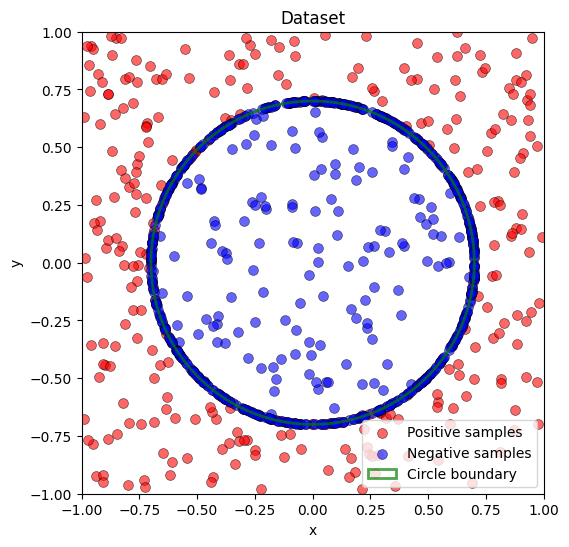

Circle SDF: sqrt(x² + y²) - 0.7
Total samples: 1000 (400 random + 600 on surface)
Positive samples (outside): 308, Negative samples (inside): 692


In [ ]:
# Create a dataset with signed distance to a circle

# Generate points with good spread across the space
n_samples_random = 400  # Random samples to cover the space
n_samples_surface = 600  # Points on the circle surface - more to learn boundary accurately

# Sample uniformly across the entire space
X_random = np.random.uniform(-1, 1, size=(n_samples_random, 2))

# Sample points directly on the circle surface
# Use uniform angles to get evenly distributed points on the circle
circle_radius = 0.7  # Larger radius to fill more of the [-1, 1] domain
angles = np.random.uniform(0, 2*np.pi, size=n_samples_surface)
X_surface = np.stack([
    circle_radius * np.cos(angles),
    circle_radius * np.sin(angles)
], axis=1)

# Combine random and surface samples
X_normalized = np.vstack([X_random, X_surface])

# Define circle SDF: distance to circle centered at origin
# Circle: sqrt(x^2 + y^2) = r
# SDF: sqrt(x^2 + y^2) - r (positive outside, negative inside)
def circle_sdf(x, y):
    # L2 distance from origin minus radius
    return np.sqrt(x**2 + y**2) - circle_radius

y_distance = circle_sdf(X_normalized[:, 0], X_normalized[:, 1])

# Clip to reasonable range
y_distance = np.clip(y_distance, -0.8, 0.8)

# Visualize the dataset
fig, ax = plt.subplots(figsize=(6, 6))

# Separate positive and negative samples
positive_mask = y_distance > 0
negative_mask = y_distance <= 0

# Plot positive samples (above boundary) in red
ax.scatter(X_normalized[positive_mask, 0], X_normalized[positive_mask, 1], 
          c='red', s=50, edgecolors='black', linewidth=0.5, label='Positive samples', alpha=0.6)

# Plot negative samples (below boundary) in blue
ax.scatter(X_normalized[negative_mask, 0], X_normalized[negative_mask, 1], 
          c='blue', s=50, edgecolors='black', linewidth=0.5, label='Negative samples', alpha=0.6)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Dataset')
ax.set_aspect('equal')

# Draw the circle boundary
circle = plt.Circle((0, 0), circle_radius, color='g', fill=False, linewidth=2, alpha=0.7, label='Circle boundary')
ax.add_patch(circle)
ax.legend()

plt.show()

print(f"Circle SDF: sqrt(x² + y²) - {circle_radius}")
print(f"Total samples: {len(X_normalized)} ({n_samples_random} random + {n_samples_surface} on surface)")
print(f"Positive samples (outside): {positive_mask.sum()}, Negative samples (inside): {negative_mask.sum()}")

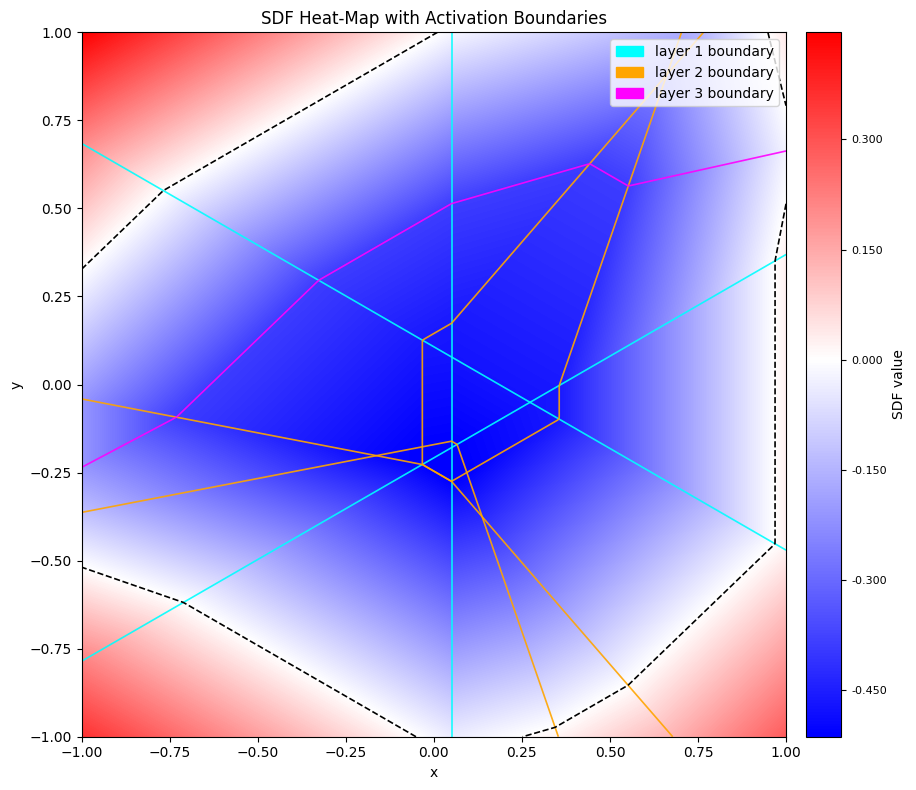

Initialized weights with zero-level sets in [-1, 1] domain


In [ ]:
# Create model with 2D input (x, y coordinates) and 1D output (SDF value)
model = ReluMLP(input_dim=2, hidden_dim=4, num_layers=2, output_dim=1)

# Better initialization: ensure zero level sets intersect the [-1, 1] domain for all layers
# Strategy: use moderate weights and small biases so boundaries appear in the visible domain
with torch.no_grad():
    np.random.seed(SEED)  # For reproducible initialization
    
    # Layer 1: Capture different orientations with zero-level sets in [-1, 1]
    # Use angles at 0°, 120°, 240° and small random biases
    angle1 = 0
    angle2 = 2 * np.pi / 3
    angle3 = 4 * np.pi / 3
    weight_scale = 1.5  # Moderate scale for stable gradients
    
    model.layers[0].weight.data = torch.FloatTensor([
        [weight_scale * np.cos(angle1), weight_scale * np.sin(angle1)],
        [weight_scale * np.cos(angle2), weight_scale * np.sin(angle2)],
        [weight_scale * np.cos(angle3), weight_scale * np.sin(angle3)]
    ])
    # Small biases to ensure boundaries intersect [-1, 1] domain
    model.layers[0].bias.data = torch.FloatTensor([
        np.random.uniform(-0.3, 0.3),
        np.random.uniform(-0.3, 0.3),
        np.random.uniform(-0.3, 0.3)
    ])
    
    # Layer 2: Combine layer 1 outputs with moderate weights and small biases
    model.layers[2].weight.data = torch.FloatTensor([
        [0.6, 0.6, -0.3],
        [-0.3, 0.6, 0.6],
        [0.6, -0.3, 0.6]
    ])
    model.layers[2].bias.data = torch.FloatTensor([
        np.random.uniform(-0.4, 0.4),
        np.random.uniform(-0.4, 0.4),
        np.random.uniform(-0.4, 0.4)
    ])
    
    # Layer 3: Further combination with boundaries in visible range
    # model.layers[4].weight.data = torch.FloatTensor([
    #     [0.5, 0.5, -0.3],
    #     [-0.3, 0.5, 0.5],
    #     [0.5, -0.3, 0.5]
    # ])
    # model.layers[4].bias.data = torch.FloatTensor([
    #     np.random.uniform(-0.5, 0.5),
    #     np.random.uniform(-0.5, 0.5),
    #     np.random.uniform(-0.5, 0.5)
    # ])
    
    # Output layer: combine all with bias targeting circle radius
    model.layers[4].weight.data = torch.FloatTensor([[0.7, 0.7, 0.7]])
    model.layers[4].bias.data = torch.FloatTensor([-circle_radius * 1.2])

plot_cell_sdf(model)
print("Initialized weights with zero-level sets in [-1, 1] domain")


=== Training with MSE Loss ===


Training: 100%|██████████| 5000/5000 [00:49<00:00, 100.18it/s, MSE Loss=0.000232, Best=0.000229]



Best loss: 0.000229
Loaded best model from training


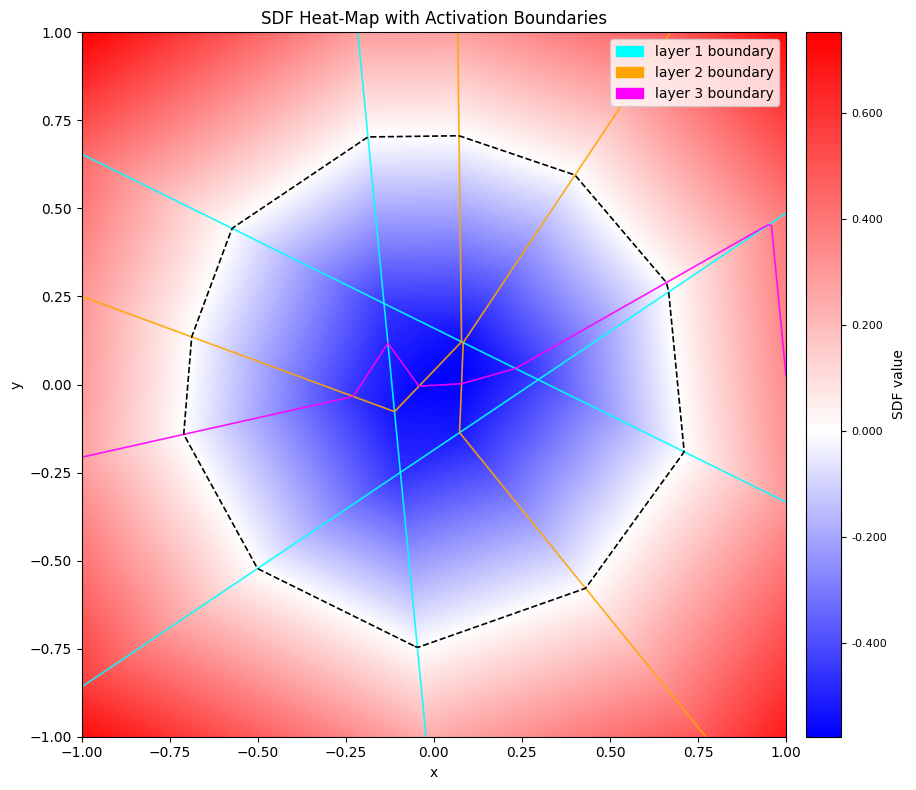

In [ ]:
# Move model to device
model = model.to(device)
# Keep dataset on CPU, move batches to device in training loop
X_tensor = torch.FloatTensor(X_normalized)
y_tensor = torch.FloatTensor(y_distance).reshape(-1, 1)
    
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)  # Lower LR for stable training with scaled weights
# Create DataLoader for batch gradient descent
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
batch_size = 500  # Large batch size for fast, stable training
dataset = TensorDataset(X_tensor, y_tensor)
# Create generator for reproducible DataLoader shuffling
generator = torch.Generator()
generator.manual_seed(SEED)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)
# Training with MSE loss only
print("\n=== Training with MSE Loss ===")
num_epochs = 5000
best_loss = float('inf')
best_model_state = None

pbar = tqdm(range(num_epochs), desc="Training")
for epoch in pbar:
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Move batch to device (DataLoader doesn't do this automatically)
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    # Save best model (based on MSE loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict().copy()
    
    # Update progress bar with loss information
    pbar.set_postfix({'MSE Loss': f'{avg_loss:.6f}', 'Best': f'{best_loss:.6f}'})

# Load best model
print(f'\nBest loss: {best_loss:.6f}')
model.load_state_dict(best_model_state)
print("Loaded best model from training")
plot_cell_sdf(model)

Saving plots to: results/neuron_plots

=== Plotting Hidden Layer 1 ===
Hidden Layer 1 - Neuron 1


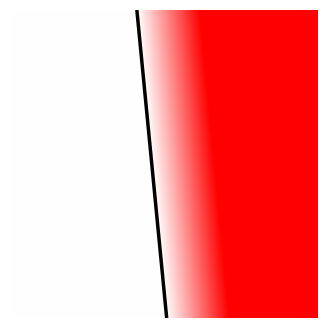

Hidden Layer 1 - Neuron 2


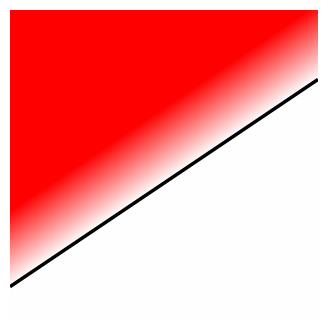

Hidden Layer 1 - Neuron 3


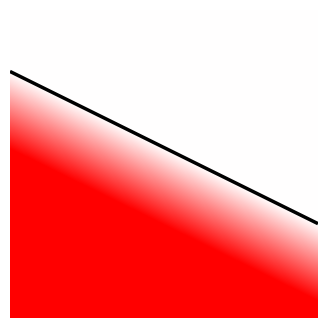


=== Plotting Hidden Layer 2 ===
Hidden Layer 2 - Neuron 1


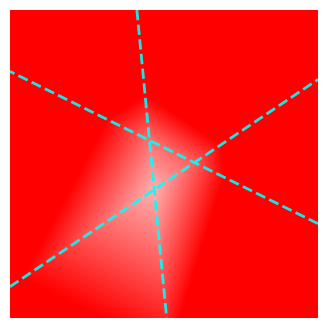

Hidden Layer 2 - Neuron 2


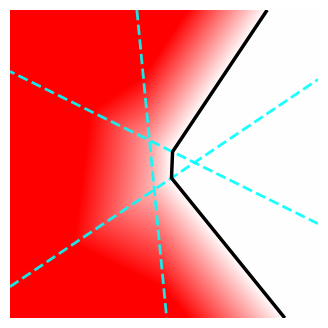

Hidden Layer 2 - Neuron 3


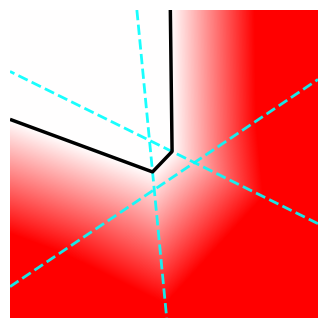


=== Plotting Hidden Layer 3 ===
Hidden Layer 3 - Neuron 1


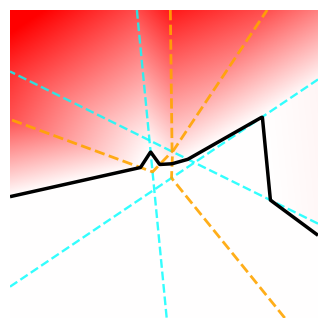

Hidden Layer 3 - Neuron 2


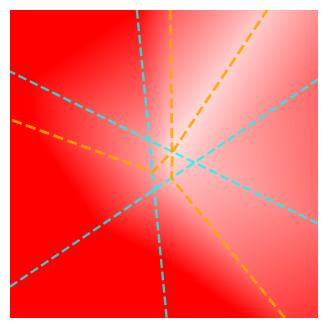

Hidden Layer 3 - Neuron 3


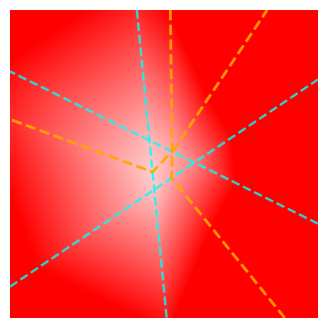


=== Plotting Output Layer ===
Output - Neuron 1


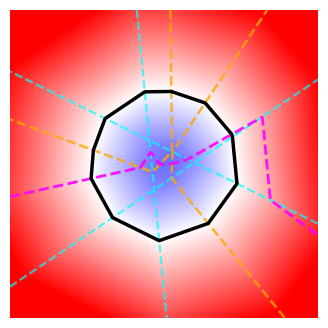


All plots saved to: results/neuron_plots


In [ ]:
#%% Helper functions for plotting
def plot_neuron(layer_name, neuron_idx, Z_after, Z_before, previous_layers_contours, 
                X_grid_xx, X_grid_yy, cmap, grid_extent, results_dir, filename):
    """
    Plot a single neuron's activation with previous layer contours.
    
    Args:
        layer_name: Name of the layer (e.g., "Layer 1")
        neuron_idx: Index of the neuron (1-indexed for display)
        Z_after: Activation after ReLU
        Z_before: Activation before ReLU (for contour)
        previous_layers_contours: List of tuples (contours_before, color, linewidth, alpha)
        X_grid_xx, X_grid_yy: Grid for contour plotting
        cmap: Colormap for the heatmap
        grid_extent: Extent of the grid
        results_dir: Directory to save results
        filename: Filename for saving
    """
    print(f"{layer_name} - Neuron {neuron_idx}")
    
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(Z_after, extent=[-grid_extent, grid_extent, -grid_extent, grid_extent], 
                   origin='lower', cmap=cmap, vmin=-1, vmax=1)
    
    # Draw previous layer contours
    for contours, color, linewidth, alpha in previous_layers_contours:
        for contour_data in contours:
            ax.contour(X_grid_xx, X_grid_yy, contour_data, levels=[0], 
                      colors=color, linewidths=linewidth, alpha=alpha, linestyles='dashed')
    
    # Draw current layer contour (before ReLU)
    ax.contour(X_grid_xx, X_grid_yy, Z_before, levels=[0], colors='black', linewidths=2.5)
    
    ax.axis('off')
    plt.savefig(f"{results_dir}/{filename}", dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_mlp_decision_boundaries(model, results_dir, grid_extent=1.5, grid_resolution=500, device='cpu'):
    """
    Generate all decision boundary visualizations for a ReLU MLP.
    
    Note: This function is designed for 2D input models only.
    
    Args:
        model: ReluMLP model (must have input_dim=2)
        results_dir: Directory to save the plots
        grid_extent: Visualization range (-grid_extent to +grid_extent)
        grid_resolution: Resolution of the grid
        device: Device to run computations on
    """
    import os
    import datetime
    
    if model.input_dim != 2:
        print(f"Warning: visualize_mlp_decision_boundaries expects 2D input, got input_dim={model.input_dim}")
        return
    
    # Create results directory
    os.makedirs(results_dir, exist_ok=True)
    print(f"Saving plots to: {results_dir}")
    
    # Setup grid
    X_grid = np.linspace(-grid_extent, grid_extent, grid_resolution)
    X_grid_xx, X_grid_yy = np.meshgrid(X_grid, X_grid)
    X_grid_flat = np.c_[X_grid_xx.ravel(), X_grid_yy.ravel()]
    X_grid_tensor = torch.FloatTensor(X_grid_flat).to(device)
    
    model.eval()
    
    # Create colormap: -1 = blue, 0 = white, 1 = red
    colors_map = ['blue', 'white', 'red']
    n_bins = 500
    cmap = LinearSegmentedColormap.from_list('custom', colors_map, N=n_bins)
    
    # Get number of layers and hidden dimensions
    num_hidden_layers = model.num_layers
    hidden_dim = model.hidden_dim
    
    # Store contours for all layers
    all_contours_before = []
    all_contours_after = []
    
    with torch.no_grad():
        x = X_grid_tensor
        
        # Process each hidden layer
        for layer_idx in range(num_hidden_layers):
            linear_idx = layer_idx * 2
            relu_idx = layer_idx * 2 + 1
            
            # Linear layer
            z = model.layers[linear_idx](x)
            z_np = z.cpu().clone().numpy()
            
            # ReLU layer
            h = model.layers[relu_idx](z)
            h_np = h.cpu().clone().numpy()
            
            # Store contours
            contours_before = []
            contours_after = []
            for i in range(hidden_dim):
                contours_before.append(z_np[:, i].reshape(grid_resolution, grid_resolution))
                contours_after.append(h_np[:, i].reshape(grid_resolution, grid_resolution))
            
            all_contours_before.append(contours_before)
            all_contours_after.append(contours_after)
            
            # Plot neurons for this layer
            print(f"\n=== Plotting Hidden Layer {layer_idx + 1} ===")
            
            # Build previous layers list
            prev_layers = []
            layer_colors = ['cyan', 'orange', 'magenta', 'yellow', 'lime']
            for prev_idx in range(layer_idx):
                color = layer_colors[prev_idx % len(layer_colors)]
                linewidth = 2.0 - (layer_idx - prev_idx - 1) * 0.3
                alpha = 0.9 - (layer_idx - prev_idx - 1) * 0.1
                prev_layers.append((all_contours_before[prev_idx], color, linewidth, alpha))
            
            # Plot each neuron
            for neuron_idx in range(hidden_dim):
                plot_neuron(f"Hidden Layer {layer_idx + 1}", neuron_idx + 1,
                           contours_after[neuron_idx], contours_before[neuron_idx],
                           prev_layers, X_grid_xx, X_grid_yy, cmap, grid_extent,
                           results_dir, f"layer{layer_idx + 1}_neuron{neuron_idx + 1}.png")
            
            # Update x for next layer
            x = h
        
        # Output layer
        print("\n=== Plotting Output Layer ===")
        output = model.layers[-1](x)
        output_np = output.cpu().numpy()
        Z_output = output_np.reshape(grid_resolution, grid_resolution)
        
        # Build previous layers list for output
        prev_layers_output = []
        for prev_idx in range(num_hidden_layers):
            color = layer_colors[prev_idx % len(layer_colors)]
            linewidth = 2.0 - (num_hidden_layers - prev_idx - 1) * 0.2
            alpha = 0.9 - (num_hidden_layers - prev_idx - 1) * 0.1
            prev_layers_output.append((all_contours_before[prev_idx], color, linewidth, alpha))
        
        plot_neuron("Output", 1, Z_output, Z_output, prev_layers_output,
                   X_grid_xx, X_grid_yy, cmap, grid_extent,
                   results_dir, "output_layer.png")
    
    print(f"\nAll plots saved to: {results_dir}")

results_dir = f"results/neuron_plots"
visualize_mlp_decision_boundaries(model, results_dir, grid_extent=1.5, grid_resolution=500, device=device)

In [ ]:
from fast_iot.hypersphere_cache import HypersphereCache

def sample_path_segment(start, end, num_samples):
    """Sample equally spaced points along a line segment."""
    t = np.linspace(0, 1, num_samples)
    path = np.array([start + t_i * (end - start) for t_i in t])
    return path

# Define path with multiple waypoints
waypoints = [
    np.array([-0.5, -0.8]),
    np.array([0.5, -0.8]),
    np.array([0.2, -0.5]),
    np.array([0.5, 0.5])
]

# Sample path with small steps between waypoints
samples_per_segment = 30  # More samples for smaller steps
path_points = []
for i in range(len(waypoints) - 1):
    segment = sample_path_segment(waypoints[i], waypoints[i + 1], samples_per_segment)
    if i > 0:
        # Skip first point to avoid duplicates at waypoints
        segment = segment[1:]
    path_points.append(segment)
path_points = np.vstack(path_points)

print(f"\n=== Path Sampling with Circle Reuse ===")
print(f"Path waypoints: {len(waypoints)} waypoints")
print(f"Number of samples: {len(path_points)}")

# Create HypersphereCache with the model
cache = HypersphereCache(model, device=device, rebuild_threshold=10)

path_results = []  # (point, circle_idx, is_reused)

for idx, point_np in enumerate(path_points):
    point = torch.FloatTensor(point_np).to(device)
    
    # Use cache to evaluate point and get linearization info
    output, W, b, circle_idx, is_cached = cache(point, return_linearization=True)
    
    # Log result
    if is_cached:
        center, radius, _, _ = cache.circles[circle_idx]
        distance_to_center = torch.norm(point - center).item()
        print(f"Point {idx}: {point_np} - REUSED circle {circle_idx} (distance={distance_to_center:.4f} < radius={radius:.4f})")
    else:
        _, radius, _, _ = cache.circles[circle_idx]
        print(f"Point {idx}: {point_np} - NEW circle {circle_idx} (radius={radius:.4f})")
    
    path_results.append((point_np.copy(), circle_idx, is_cached))

# Get cache statistics
stats = cache.get_stats()
print(f"\n=== Summary ===")
print(f"Total circles created: {stats['cache_size']}")
print(f"Total points sampled: {len(path_points)}")
print(f"Cache hits: {stats['cache_hits']}")
print(f"Cache misses: {stats['cache_misses']}")
print(f"Hit rate: {stats['hit_rate']*100:.1f}%")

# Get circles for visualization (same format as before)
circles = cache.get_circles()



=== Path Sampling with Circle Reuse ===
Path waypoints: 4 waypoints
Number of samples: 88
Point 0: [-0.5 -0.8] - NEW circle 0 (radius=0.2305)
Point 1: [-0.46551724 -0.8       ] - REUSED circle 0 (distance=0.0345 < radius=0.2305)
Point 2: [-0.43103448 -0.8       ] - REUSED circle 0 (distance=0.0690 < radius=0.2305)
Point 3: [-0.39655172 -0.8       ] - REUSED circle 0 (distance=0.1034 < radius=0.2305)
Point 4: [-0.36206897 -0.8       ] - REUSED circle 0 (distance=0.1379 < radius=0.2305)
Point 5: [-0.32758621 -0.8       ] - REUSED circle 0 (distance=0.1724 < radius=0.2305)
Point 6: [-0.29310345 -0.8       ] - REUSED circle 0 (distance=0.2069 < radius=0.2305)
Point 7: [-0.25862069 -0.8       ] - NEW circle 1 (radius=0.2160)
Point 8: [-0.22413793 -0.8       ] - REUSED circle 1 (distance=0.0345 < radius=0.2160)
Point 9: [-0.18965517 -0.8       ] - REUSED circle 1 (distance=0.0690 < radius=0.2160)
Point 10: [-0.15517241 -0.8       ] - REUSED circle 1 (distance=0.1034 < radius=0.2160)
Point 1

/tmp/ipykernel_3918497/3827046169.py:40: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0],
/tmp/ipykernel_3918497/3827046169.py:75: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((center[0].item(), center[1].item()), radius,


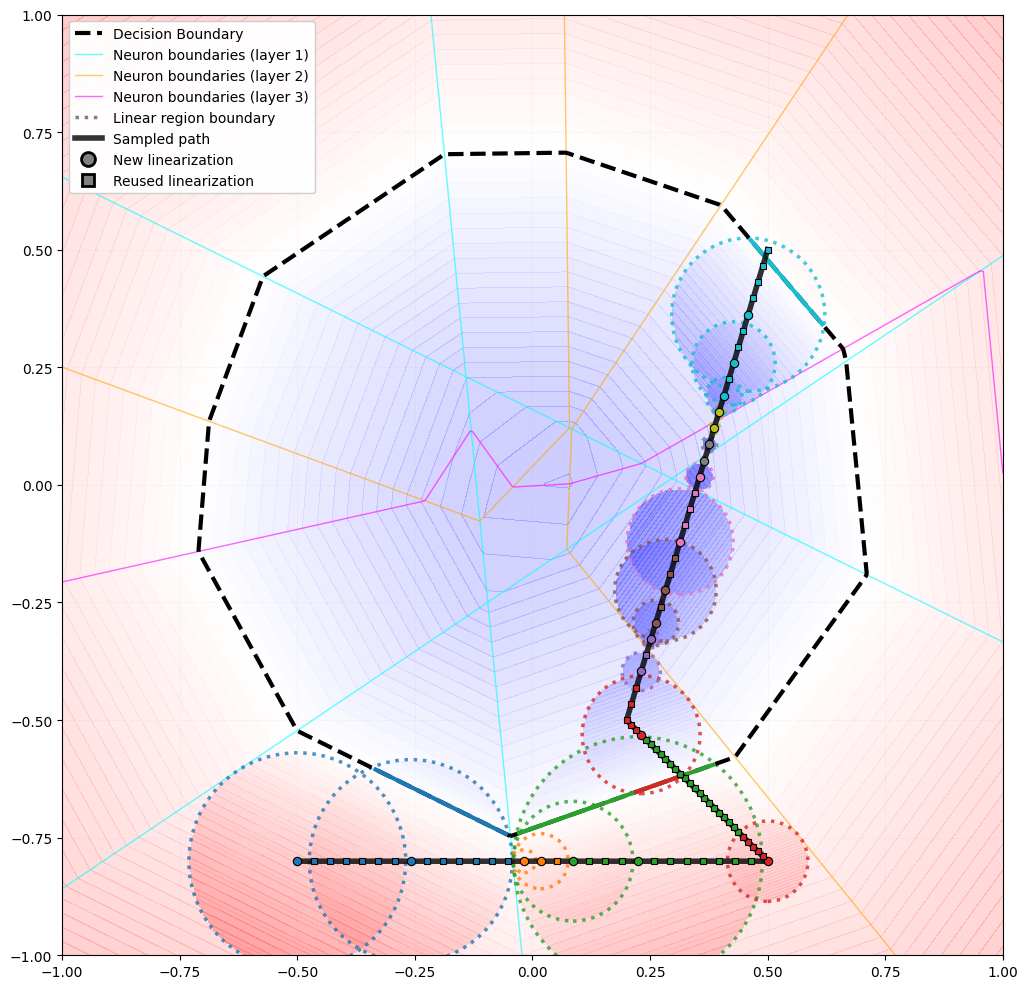


=== Circle Details ===
Circle 0: center=(-0.500, -0.800), radius=0.2305
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 1: center=(-0.259, -0.800), radius=0.2160
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 2: center=(-0.017, -0.800), radius=0.0243
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 3: center=(0.017, -0.800), radius=0.0586
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 4: center=(0.086, -0.800), radius=0.1273
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 5: center=(0.224, -0.800), radius=0.2645
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 6: center=(0.500, -0.800), radius=0.0855
  Linearized: f(x) = W @ x + b
  W shape: torch.Size([1, 2]), b shape: torch.Size([1])
Circle 7: center=(0.231, -0.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# Create grid for evaluation
x = torch.linspace(-1, 1, 400)
y = torch.linspace(-1, 1, 400)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

with torch.no_grad():
    # Compute ground truth SDF and neuron activations
    sdf_vals, preacts = model.eval_activations(grid_pts)
    sdf_grid = sdf_vals.view(400, 400).cpu().numpy()
    
    # Extract neuron pre-activations for all layers
    L = model.num_layers
    H = model.hidden_dim
    preacts = preacts.view(400, 400, L, H).cpu()
    
    # Compute linearized SDF for each circle on the grid
    linearized_grids = []
    for idx, (center, radius, W, b) in enumerate(circles):
        # Evaluate linearized function: f(x) = W @ x + b
        # W shape: (output_dim, input_dim), grid_pts shape: (N, input_dim)
        linear_vals = (W @ grid_pts.T).T + b  # Shape: (N, output_dim)
        
        # Extract scalar output (first dimension for single output models)
        if linear_vals.shape[1] == 1:
            linear_grid = linear_vals[:, 0].view(400, 400).cpu().numpy()
        else:
            linear_grid = linear_vals[:, 0].view(400, 400).cpu().numpy()
        
        linearized_grids.append(linear_grid)

# Plot ground truth SDF background
cmap_bg = LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'])
norm_bg = TwoSlopeNorm(vmin=sdf_grid.min(), vcenter=0, vmax=sdf_grid.max())
ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=50, cmap=cmap_bg, norm=norm_bg, alpha=0.2)

# Plot zero level set of ground truth
ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], 
          colors='black', linewidths=3, linestyles='--', label='Decision Boundary', zorder=5)

# Plot neuron activation boundaries (pre-ReLU contours) to verify circle radii
neuron_colors = ['cyan', 'orange', 'magenta', 'yellow', 'lime', 'red', 'purple', 'brown']
for l in range(L):
    rgba = plt.matplotlib.colors.to_rgba(neuron_colors[l % len(neuron_colors)])
    for h in range(H):
        ax.contour(xx.cpu(), yy.cpu(), preacts[:, :, l, h], levels=[0],
                  linewidths=1.0, colors=[rgba], alpha=0.6, zorder=2)

# Plot linearized regions and their zero level sets
circle_colors = plt.cm.tab10(np.linspace(0, 1, len(circles)))
for idx, (center, radius, W, b) in enumerate(circles):
    linear_grid = linearized_grids[idx]
    
    # Create a mask for points inside the circle (valid region)
    xx_np = xx.cpu().numpy()
    yy_np = yy.cpu().numpy()
    dist_from_center = np.sqrt((xx_np - center[0].item())**2 + (yy_np - center[1].item())**2)
    inside_circle = dist_from_center <= radius
    
    # Create masked linear grid (only show inside circle)
    masked_linear_grid = np.ma.masked_where(~inside_circle, linear_grid)
    
    # Plot heatmap of linearized function within the circle
    im_linear = ax.contourf(xx_np, yy_np, masked_linear_grid, levels=30, 
                            cmap=cmap_bg, norm=norm_bg, alpha=0.4, zorder=3)
    
    # Plot zero level set of linearized function (inside circle only)
    ax.contour(xx_np, yy_np, masked_linear_grid, levels=[0], 
              colors=[circle_colors[idx]], linewidths=3, linestyles='-', 
              alpha=1.0, zorder=6)
    
    # Plot the circle boundary (where linearization validity ends)
    circle = plt.Circle((center[0].item(), center[1].item()), radius, 
                        color=circle_colors[idx], fill=False, 
                        edgecolor=circle_colors[idx], linewidth=2.5, 
                        linestyle=':', alpha=0.8, zorder=4)
    ax.add_patch(circle)
    
    # Mark center
    ax.plot(center[0].item(), center[1].item(), 'o', color=circle_colors[idx], 
            markersize=5, markeredgecolor='black', markeredgewidth=1, zorder=10)

# Plot path
path_x = path_points[:, 0]
path_y = path_points[:, 1]
ax.plot(path_x, path_y, 'k-', linewidth=4, alpha=0.8, label='Sampled path', zorder=7)

# Plot path points
for idx, (point, circle_idx, is_reused) in enumerate(path_results):
    marker = 'o' if not is_reused else 's'
    color = circle_colors[circle_idx]
    size = 6 if not is_reused else 5
    ax.plot(point[0], point[1], marker, color=color, markersize=size, 
            markeredgecolor='black', markeredgewidth=0.8, zorder=15)

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=3, linestyle='--', label='Decision Boundary'),
    Line2D([0], [0], color='cyan', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 1)'),
    Line2D([0], [0], color='orange', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 2)'),
    Line2D([0], [0], color='magenta', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 3)'),
    Line2D([0], [0], color='gray', linewidth=2.5, linestyle=':', label='Linear region boundary'),
    Line2D([0], [0], color='black', linewidth=4, alpha=0.8, label='Sampled path'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, 
           markeredgecolor='black', markeredgewidth=2, label='New linearization', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, 
           markeredgecolor='black', markeredgewidth=2, label='Reused linearization', linestyle='None'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.95)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n=== Circle Details ===")
for idx, (center, radius, W, b) in enumerate(circles):
    print(f"Circle {idx}: center=({center[0].item():.3f}, {center[1].item():.3f}), radius={radius:.4f}")
    print(f"  Linearized: f(x) = W @ x + b")
    print(f"  W shape: {W.shape}, b shape: {b.shape}")

/tmp/ipykernel_3918497/4154275384.py:98: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((center[0].item(), center[1].item()), radius,


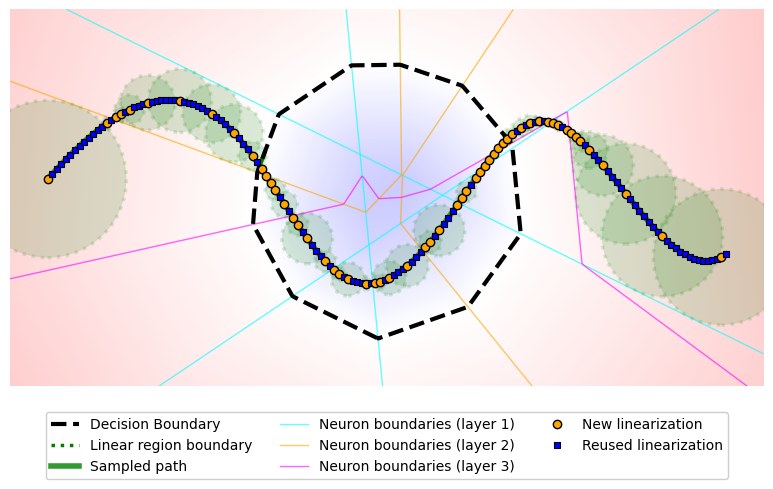


=== Caching Statistics ===
Total circles created: 57
Total points sampled: 150
Cache hits: 93
Cache misses: 57
Hit rate: 62.0%


In [ ]:
from fast_iot.hypersphere_cache import HypersphereCache
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline

def create_smooth_curve(start_x, end_x, num_points=150):
    """Create a smooth curved path from left to right."""
    x = np.linspace(start_x, end_x, 8)
    # Create y-values with smooth variation
    y = np.array([0.1, 0.5, 0.3, -0.4, -0.2, 0.4, 0.0, -0.3])
    
    # Create cubic spline
    cs = CubicSpline(x, y)
    
    # Generate smooth path
    x_smooth = np.linspace(start_x, end_x, num_points)
    y_smooth = cs(x_smooth)
    
    return np.column_stack([x_smooth, y_smooth])

# Create smooth curved path from left to right
path_points = create_smooth_curve(-1.8, 1.8, num_points=150)

# Create HypersphereCache and process path
cache = HypersphereCache(model, device=device, rebuild_threshold=10)
path_results = []

for point_np in path_points:
    point = torch.FloatTensor(point_np).to(device)
    output, W, b, circle_idx, is_cached = cache(point, return_linearization=True)
    path_results.append((point_np.copy(), circle_idx, is_cached))

circles = cache.get_circles()

# Visualization
fig, ax = plt.subplots(figsize=(15, 5))

# Create grid for evaluation
x = torch.linspace(-2, 2, 500)
y = torch.linspace(-1, 1, 250)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

with torch.no_grad():
    sdf_vals, preacts = model.eval_activations(grid_pts)
    sdf_grid = sdf_vals.view(250, 500).cpu().numpy()
    
    L = model.num_layers
    H = model.hidden_dim
    preacts = preacts.view(250, 500, L, H).cpu()
    
    linearized_grids = []
    for idx, (center, radius, W, b) in enumerate(circles):
        linear_vals = (W @ grid_pts.T).T + b
        linear_grid = linear_vals[:, 0].view(250, 500).cpu().numpy()
        linearized_grids.append(linear_grid)

# Plot ground truth SDF background (no contour lines)
cmap_bg = LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'])
norm_bg = TwoSlopeNorm(vmin=sdf_grid.min(), vcenter=0, vmax=sdf_grid.max())
ax.imshow(sdf_grid, extent=[-2, 2, -1, 1], origin='lower', cmap=cmap_bg, norm=norm_bg, alpha=0.2, aspect='auto')

# Plot zero level set of ground truth - FIXED: Higher zorder to draw on top
ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], 
          colors='black', linewidths=3, linestyles='--', zorder=10)

# Plot neuron activation boundaries
neuron_colors = ['cyan', 'orange', 'magenta', 'yellow', 'lime', 'red', 'purple', 'brown']
for l in range(L):
    rgba = plt.matplotlib.colors.to_rgba(neuron_colors[l % len(neuron_colors)])
    for h in range(H):
        ax.contour(xx.cpu(), yy.cpu(), preacts[:, :, l, h], levels=[0],
                  linewidths=1.0, colors=[rgba], alpha=0.6, zorder=2)

# Use green color for all circles
green_color = 'green'

# Plot linearized regions with green circles
for idx, (center, radius, W, b) in enumerate(circles):
    linear_grid = linearized_grids[idx]
    
    xx_np = xx.cpu().numpy()
    yy_np = yy.cpu().numpy()
    dist_from_center = np.sqrt((xx_np - center[0].item())**2 + (yy_np - center[1].item())**2)
    inside_circle = dist_from_center <= radius
    
    masked_linear_grid = np.ma.masked_where(~inside_circle, linear_grid)
    
    # Plot contour in green
    ax.contour(xx_np, yy_np, masked_linear_grid, levels=[0], 
              colors=[green_color], linewidths=3, linestyles='-', 
              alpha=1.0, zorder=6)
    
    # Green circles with differentiated alpha: low fill, high edge
    circle = plt.Circle((center[0].item(), center[1].item()), radius, 
                        color=green_color, fill=True, alpha=0.15,
                        edgecolor=green_color, linewidth=2.5, 
                        linestyle=':', zorder=4)
    # Set edge alpha separately
    circle.set_edgecolor((*plt.matplotlib.colors.to_rgba(green_color)[:3], 0.8))
    ax.add_patch(circle)
    
    # Center markers in green
    ax.plot(center[0].item(), center[1].item(), 'o', color=green_color, 
            markersize=5, markeredgecolor='black', markeredgewidth=1, zorder=10)

# Plot path in green
path_x = path_points[:, 0]
path_y = path_points[:, 1]
ax.plot(path_x, path_y, color=green_color, linewidth=4, alpha=0.8, zorder=7)

# Plot path points in green
for idx, (point, circle_idx, is_reused) in enumerate(path_results):
    if not is_reused:
        # New linearization: orange circles
        ax.plot(point[0], point[1], 'o', color='orange', markersize=6, 
                markeredgecolor='black', markeredgewidth=1, zorder=15)
    else:
        # Reused linearization: blue squares (smaller)
        ax.plot(point[0], point[1], 's', color='blue', markersize=4, 
                markeredgecolor='black', markeredgewidth=0.8, zorder=15)

# Improved legend with corrected colors
legend_col1 = [
    Line2D([0], [0], color='black', linewidth=3, linestyle='--', label='Decision Boundary'),
    Line2D([0], [0], color='green', linewidth=2.5, linestyle=':', label='Linear region boundary'),
    Line2D([0], [0], color='green', linewidth=4, alpha=0.8, label='Sampled path'),
]

legend_col2 = [
    Line2D([0], [0], color='cyan', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 1)'),
    Line2D([0], [0], color='orange', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 2)'),
    Line2D([0], [0], color='magenta', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 3)'),
]

# FIXED: Legend markers now match the actual plot colors
legend_col3 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, 
           markeredgecolor='black', markeredgewidth=1, label='New linearization', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=4, 
           markeredgecolor='black', markeredgewidth=0.8, label='Reused linearization', linestyle='None'),
]

# Combine all legend elements in order (column by column for ncol=3)
legend_elements = legend_col1 + legend_col2 + legend_col3

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
          ncol=3, fontsize=10, framealpha=0.95, columnspacing=2.0)

ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig("results/hypersphere_cache_visualization.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Print caching statistics
stats = cache.get_stats()
print(f"\n=== Caching Statistics ===")
print(f"Total circles created: {stats['cache_size']}")
print(f"Total points sampled: {len(path_points)}")
print(f"Cache hits: {stats['cache_hits']}")
print(f"Cache misses: {stats['cache_misses']}")
print(f"Hit rate: {stats['hit_rate']*100:.1f}%")

/tmp/ipykernel_3918497/3679001512.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((center[0].item(), center[1].item()), radius,


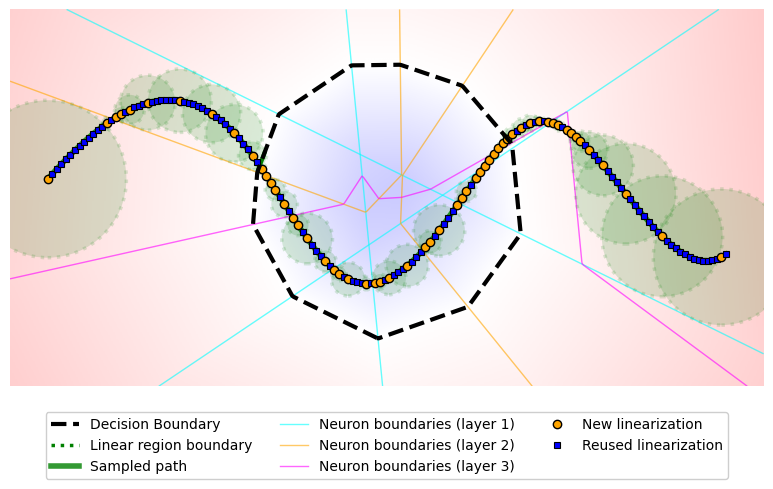


=== Caching Statistics ===
Total circles created: 57
Total points sampled: 150
Cache hits: 93
Cache misses: 57
Hit rate: 62.0%


In [ ]:
from fast_iot.hypersphere_cache import HypersphereCache
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.lines import Line2D
from scipy.interpolate import CubicSpline

def create_smooth_curve(start_x, end_x, num_points=150):
    """Create a smooth curved path from left to right."""
    x = np.linspace(start_x, end_x, 8)
    # Create y-values with smooth variation
    y = np.array([0.1, 0.5, 0.3, -0.4, -0.2, 0.4, 0.0, -0.3])
    
    # Create cubic spline
    cs = CubicSpline(x, y)
    
    # Generate smooth path
    x_smooth = np.linspace(start_x, end_x, num_points)
    y_smooth = cs(x_smooth)
    
    return np.column_stack([x_smooth, y_smooth])

# Create smooth curved path from left to right
path_points = create_smooth_curve(-1.8, 1.8, num_points=150)

# Create HypersphereCache and process path
cache = HypersphereCache(model, device=device, rebuild_threshold=10)
path_results = []

for point_np in path_points:
    point = torch.FloatTensor(point_np).to(device)
    output, W, b, circle_idx, is_cached = cache(point, return_linearization=True)
    path_results.append((point_np.copy(), circle_idx, is_cached))

circles = cache.get_circles()

# Visualization
fig, ax = plt.subplots(figsize=(15, 5))

# Create grid for evaluation
x = torch.linspace(-2, 2, 500)
y = torch.linspace(-1, 1, 250)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid_pts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

with torch.no_grad():
    sdf_vals, preacts = model.eval_activations(grid_pts)
    sdf_grid = sdf_vals.view(250, 500).cpu().numpy()
    
    L = model.num_layers
    H = model.hidden_dim
    preacts = preacts.view(250, 500, L, H).cpu()
    
    linearized_grids = []
    for idx, (center, radius, W, b) in enumerate(circles):
        linear_vals = (W @ grid_pts.T).T + b
        linear_grid = linear_vals[:, 0].view(250, 500).cpu().numpy()
        linearized_grids.append(linear_grid)

# Plot ground truth SDF background (no contour lines)
cmap_bg = LinearSegmentedColormap.from_list('custom', ['blue', 'white', 'red'])
norm_bg = TwoSlopeNorm(vmin=sdf_grid.min(), vcenter=0, vmax=sdf_grid.max())
ax.imshow(sdf_grid, extent=[-2, 2, -1, 1], origin='lower', cmap=cmap_bg, norm=norm_bg, alpha=0.2, aspect='auto')

# Plot neuron activation boundaries
neuron_colors = ['cyan', 'orange', 'magenta', 'yellow', 'lime', 'red', 'purple', 'brown']
for l in range(L):
    rgba = plt.matplotlib.colors.to_rgba(neuron_colors[l % len(neuron_colors)])
    for h in range(H):
        ax.contour(xx.cpu(), yy.cpu(), preacts[:, :, l, h], levels=[0],
                  linewidths=1.0, colors=[rgba], alpha=0.6, zorder=2)

# Use green color for all circles
green_color = 'green'

# Plot linearized regions with green circles
for idx, (center, radius, W, b) in enumerate(circles):
    linear_grid = linearized_grids[idx]
    
    xx_np = xx.cpu().numpy()
    yy_np = yy.cpu().numpy()
    dist_from_center = np.sqrt((xx_np - center[0].item())**2 + (yy_np - center[1].item())**2)
    inside_circle = dist_from_center <= radius
    
    masked_linear_grid = np.ma.masked_where(~inside_circle, linear_grid)
    
    # Plot contour in green
    ax.contour(xx_np, yy_np, masked_linear_grid, levels=[0], 
              colors=[green_color], linewidths=3, linestyles='-', 
              alpha=1.0, zorder=6)
    
    # Green circles with differentiated alpha: low fill, high edge
    circle = plt.Circle((center[0].item(), center[1].item()), radius, 
                        color=green_color, fill=True, alpha=0.15,
                        edgecolor=green_color, linewidth=2.5, 
                        linestyle=':', zorder=4)
    # Set edge alpha separately
    circle.set_edgecolor((*plt.matplotlib.colors.to_rgba(green_color)[:3], 0.8))
    ax.add_patch(circle)
    
    # Center markers in green
    ax.plot(center[0].item(), center[1].item(), 'o', color=green_color, 
            markersize=5, markeredgecolor='black', markeredgewidth=1, zorder=10)

# Plot path in green
path_x = path_points[:, 0]
path_y = path_points[:, 1]
ax.plot(path_x, path_y, color=green_color, linewidth=4, alpha=0.8, zorder=7)

# Plot path points
for idx, (point, circle_idx, is_reused) in enumerate(path_results):
    if not is_reused:
        # New linearization: circles
        ax.plot(point[0], point[1], 'o', color='orange', markersize=6, 
                markeredgecolor='black', markeredgewidth=1, zorder=15)
    else:
        # Reused linearization: squares (smaller)
        ax.plot(point[0], point[1], 's', color='blue', markersize=4, 
                markeredgecolor='black', markeredgewidth=0.8, zorder=15)

# FIXED: Plot zero level set of ground truth AFTER green contours with higher zorder
ax.contour(xx.cpu().numpy(), yy.cpu().numpy(), sdf_grid, levels=[0], 
          colors='black', linewidths=3, linestyles='--', zorder=20)

# Improved legend with corrected colors
legend_col1 = [
    Line2D([0], [0], color='black', linewidth=3, linestyle='--', label='Decision Boundary'),
    Line2D([0], [0], color='green', linewidth=2.5, linestyle=':', label='Linear region boundary'),
    Line2D([0], [0], color='green', linewidth=4, alpha=0.8, label='Sampled path'),
]

legend_col2 = [
    Line2D([0], [0], color='cyan', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 1)'),
    Line2D([0], [0], color='orange', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 2)'),
    Line2D([0], [0], color='magenta', linewidth=1, alpha=0.6, label='Neuron boundaries (layer 3)'),
]

legend_col3 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, 
           markeredgecolor='black', markeredgewidth=1, label='New linearization', linestyle='None'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=4, 
           markeredgecolor='black', markeredgewidth=0.8, label='Reused linearization', linestyle='None'),
]

# Combine all legend elements in order (column by column for ncol=3)
legend_elements = legend_col1 + legend_col2 + legend_col3

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
          ncol=3, fontsize=10, framealpha=0.95, columnspacing=2.0)

ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig("results/hypersphere_cache_visualization.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

# Print caching statistics
stats = cache.get_stats()
print(f"\n=== Caching Statistics ===")
print(f"Total circles created: {stats['cache_size']}")
print(f"Total points sampled: {len(path_points)}")
print(f"Cache hits: {stats['cache_hits']}")
print(f"Cache misses: {stats['cache_misses']}")
print(f"Hit rate: {stats['hit_rate']*100:.1f}%")